# Use a Vmax weighting scheme to calculate the gas 'deficiency' parameter

In [1]:
os.chdir('../../')

In [2]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os
import time

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

from palettable.colorbrewer.sequential import Greys_9
from scipy.optimize import curve_fit

from astropy.cosmology import FlatLambdaCDM
from calc_kcor import calc_kcor
cosmo=FlatLambdaCDM(H0=70,Om0=0.3) # Use standard cosmology model from astropy.

import make_dictionaries
questions = make_dictionaries.questions

Load all of the required data:

In [3]:
sample = Table.read('../fits/full_sample_debiased_w_low_z.fits')
print('Loaded galaxy data...')
a70 = Table.read('../fits/ALFALFA/a70.csv')
print('Loaded ALFA70...')
matches = Table.read('sdss_alfa70_matches.fits')
print('Got matches!')

Loaded galaxy data...
Loaded ALFA70...
Got matches!


In [4]:
has_gas = matches['i_alfa'] != -999
matched_gas = a70[matches['i_alfa'].astype(int)[has_gas]]

for c in ['HIra','HIdec','dist','loghimass','detcode']:
    column = np.ones(len(sample))*(-999)
    column[has_gas] = matched_gas[c].data
    sample[c] = column
    
in_redshift = (sample['REDSHIFT_1'] <= 0.05) & (sample['REDSHIFT_1'] >= 0.02)

print('{} galaxies in the 0.02<z<0.05 range.'.format(np.sum(in_redshift)))

55397 galaxies in the 0.02<z<0.05 range.


Calculate the limits above which we are M* complete:

In [5]:
def get_sample_limits(z): # get the luminosity limit for a given sample
    z_max = [z]
    D_max=(10**6)*(np.array(cosmo.luminosity_distance(z_max))[0])
    m_limit=17
    k_val = calc_kcor('r',z,'g - r',0.8)
    M_limit=m_limit - 5*(math.log10(D_max) - 1) - k_val
    return M_limit


def baldry_equation(u_r): # conversion of colour to mass?
    if u_r < 79/38:
        return -0.95 + 0.56*(u_r)
    else:
        return -0.16 + 0.18*(u_r)
    
    
def lum_to_mag(L):
    return -2.5*math.log10(L) + 4.67


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx


def get_volume_and_mass_limits(z_values,full_data,z_min=0.03):
    
    mass_limit = np.logspace(9.5,12,1000)
    masses = []
    
    # First, get a set of 'reference' M + z values:
    z_references = np.linspace(0.03,0.2,1000)
    M_references = []
    for z in z_references:
        M_references.append(get_sample_limits(z))
    M_references = np.array([M_references])
    #----------------------------------------------
    # our data:
    u_r = full_data['PETROMAG_MU'] - full_data['PETROMAG_MR']
    Mr = full_data['PETROMAG_MR']
    
    for z in z_values:
        M_limit = get_sample_limits(z)
        in_volume_limit = ((full_data['REDSHIFT_1'] > z_min) &
                           (full_data['REDSHIFT_1'] <= z) &
                           (full_data['PETROMAG_MR'] <= M_limit))
        
        vl_ur = u_r[in_volume_limit]
        ur_99 = np.percentile(vl_ur,99,axis=0)
        logML = baldry_equation(ur_99)
        
        z_for_masses = []
        for mass in mass_limit:
            L_limit = (10**(-logML))*mass
            M_limit_mass = lum_to_mag(L_limit)
            i = find_nearest(M_references,M_limit_mass)
            z_limit = z_references[i]
            z_for_masses.append(z_limit)
        
        i2 = find_nearest(z,z_for_masses)
        masses.append(mass_limit[i2])
    
    log_masses = np.log10(masses)
    return log_masses

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


M* completeness limit: 
 log(M_*)=2.12 log(z) + 12.92
34168/55397 galaxies in the M* complete sample (61.7%)


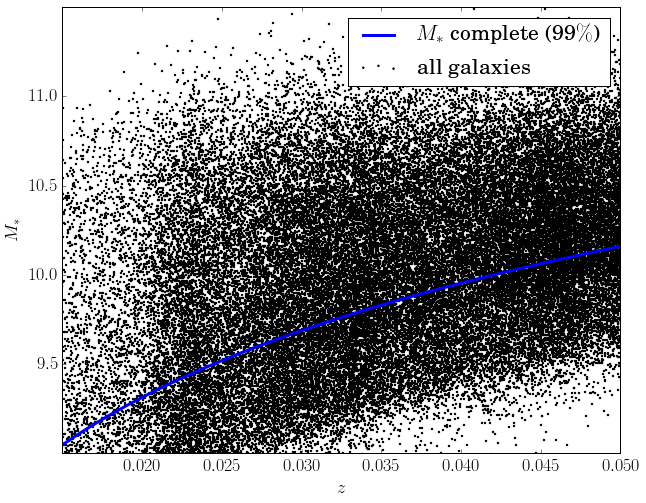

In [6]:
from scipy.optimize import curve_fit

def log_fun(x,m,c):
    return m*np.log10(x) + c

z_values = np.linspace(0.031,0.05,100)
masses = get_volume_and_mass_limits(z_values,sample)

_ = plt.scatter(sample['REDSHIFT_1'],sample['LOGMSTAR_BALDRY06']
                ,s=2,color='k',label='all galaxies')

p_mass,_ = curve_fit(log_fun,z_values,masses)
x_guide = np.linspace(0.01,0.1,100)
_ = plt.plot(x_guide,log_fun(x_guide,*p_mass),'b-',lw=3,label='$M_*$ complete (99$\%$)')
plt.xlabel('$z$')
plt.ylabel('$M_*$')

print('M* completeness limit: \n log(M_*)={} log(z) + {}'.format(np.round(p_mass[0],decimals=2),
                                                                   np.round(p_mass[1],decimals=2)))

plt.axis([0.015,0.05,9,11.5])
_ = plt.legend()

in_mass = sample['LOGMSTAR_BALDRY06'] >= log_fun(sample['REDSHIFT_1'],*p_mass)
print('{}/{} galaxies in the M* complete sample ({}%)'.format(np.sum(in_mass[in_redshift]),len(in_mass[in_redshift])
                                                              ,np.round(100*np.sum(in_mass[in_redshift])/len(in_mass[in_redshift]),decimals=1)))

Do the same for the 5$\sigma$ gas completeness:

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


20049/25535 detections in the 5sigma complete sample (78.5%)
16517/25535 detections in the 0.02<z<0.05 range (64.7%)


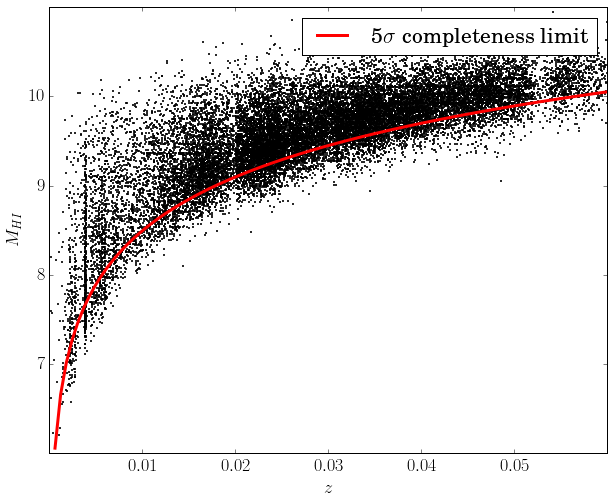

In [7]:
def mass_from_redshift(z):
    K = 2.356e5*((3e5/70)**2) # constant for converting between flux and mass
    mass_limit = np.log10(K*(z**2)*0.72)
    return mass_limit


def redshift_from_dist(D):
    return (70/3e5)*D


z = np.linspace(0,0.06,100)
_ = plt.plot(z,mass_from_redshift(z),'r-',lw=3,label='5$\sigma$ completeness limit')
_ = plt.legend()
plt.xlabel('$z$')
plt.ylabel('$M_{HI}$')

a70['redshift'] = redshift_from_dist(a70['dist'])
_ = plt.scatter(a70['redshift'],a70['loghimass'],color='k',s=1)
plt.axis([0,0.06,6,11])

in_5sigma_limit = a70['loghimass'] >= mass_from_redshift(a70['redshift'])
print('{}/{} detections in the 5sigma complete sample ({}%)'.format(np.sum(in_5sigma_limit),len(in_5sigma_limit)
                                                                  ,np.round(100*np.sum(in_5sigma_limit)/len(in_5sigma_limit),decimals=1)))

in_gas_redshift = (a70['redshift'] >= 0.02) & (a70['redshift'] <= 0.05)

print('{}/{} detections in the 0.02<z<0.05 range ({}%)'.format(np.sum(in_gas_redshift),len(in_gas_redshift)
                                                                  ,np.round(100*np.sum(in_gas_redshift)/len(in_gas_redshift),decimals=1)))

In [8]:
def redshift_from_gas_mass(logmass):
    K = 2.356e5*((3e5/70)**2) # constant for converting between flux and mass
    mass = 10**(logmass)
    z_limit = (mass/(0.72*K))**(0.5)
    return z_limit


def redshift_from_mass(logmass):
    mass = 10**logmass
    z_limit = (10**(np.log10(mass)-p_mass[1]))**(1/p_mass[0])
    return z_limit


def get_z_limit(log_stellar_mass,log_hi_mass,survey_limit=0.05):
    
    survey_array = np.ones(len(log_stellar_mass))*survey_limit
    z_limit_gas = redshift_from_gas_mass(log_hi_mass)
    z_limit_stellar = redshift_from_mass(log_stellar_mass)
    low_z = np.min(np.array([z_limit_gas,z_limit_stellar,survey_array]).T,axis=1)
    return low_z

In [9]:
in_mass_limit = sample['LOGMSTAR_BALDRY06'] >= log_fun(sample['REDSHIFT_1'],*p_mass)
sample['in_mass_limit'] = in_mass_limit

gas_redshift = np.ones(len(sample))*(-999)
gas_redshift[has_gas] = redshift_from_dist(sample[has_gas]['dist'])
sample['gas_redshift'] = gas_redshift
in_hi_limit = sample['loghimass'] >= mass_from_redshift(sample['gas_redshift'])
print('{}/{} HI detections are in the >5sigma detection limit'.format(in_hi_limit.sum()
                                                                           ,len(in_hi_limit)))

sample['in_hi_limit'] = in_hi_limit

8102/248883 HI detections are in the >5sigma detection limit


Look at $V_{max}$ method here:

$V'_{max,i} = \frac{\rho_{ddp}(z_1:z_{max,i})}{\rho_{ddp}(z_1:z_2)} V_{max,i}$

In [10]:
import astropy.units as u
import astropy.coordinates as coord

def get_spatial_cut(ra,dec):
    
    ra_min = coord.ICRS(ra=7.5,dec=10,unit=(u.hourangle, u.degree))
    ra_max = coord.ICRS(ra=16.5,dec=10,unit=(u.hourangle,u.degree))
    ra_limits = [ra_min.ra.deg,ra_max.ra.deg]
    select_ra = (ra >= ra_limits[0]) & (ra <= ra_limits[1])
    select_dec1 = (dec >= 0) & (dec <= 22)
    select_dec2 = (dec >= 24) & (dec <= 30)
    select_dec = [any(s) for s in zip(select_dec1,select_dec2)]
    select_spatial = (select_ra) & (select_dec)

    print('{}/{} of SDSS sample in the ALFALFA-70 *spatial* coverage'.format(np.sum(select_spatial),len(select_spatial))
          + ' ({0:.1f}%)'.format(np.sum(select_spatial)/len(select_spatial)*100))
    
    return select_spatial

In [11]:
lum_limit = get_sample_limits(0.05)
print('luminosity-limited sample: Mr <= {}'.format(np.round(lum_limit,decimals=2)))
in_volume_limit = (sample['PETROMAG_MR'] <= lum_limit) & (sample['REDSHIFT_1'] >= 0.02) & (sample['REDSHIFT_1'] <= 0.05)
ddp = sample[in_volume_limit]
select_spatial = get_spatial_cut(ddp['ra_1'],ddp['dec_1'])
ddp = ddp[select_spatial]

luminosity-limited sample: Mr <= -19.78
17614/35938 of SDSS sample in the ALFALFA-70 *spatial* coverage (49.0%)


In [12]:
# now calculate V'max for each of the samples:

def get_rho_factor(ddp):
    
    low_z = np.min(ddp['REDSHIFT_1'])
    high_z = np.max(ddp['REDSHIFT_1'])
    
    ddp = ddp[np.argsort(ddp['REDSHIFT_1'])]
    rho_z1_z2 = len(ddp)/(high_z**3-low_z**3)
    rho = []
    z = []
    
    z_vals = np.linspace(np.min(ddp['REDSHIFT_1']),np.max(ddp['REDSHIFT_1']),100)
    
    for zi in z_vals:
        ddp_i = ddp[ddp['REDSHIFT_1'] <= zi]
        rho_z1_zi = len(ddp_i)/(zi**3-low_z**3)
        rho.append(rho_z1_zi/rho_z1_z2)
        z.append(zi)
        
    rho_vs_z = Table(np.array([z,rho]).T,names=('z','rho'))
    rho_vs_z = rho_vs_z[np.isfinite(rho_vs_z['rho'])]
        
    return rho_vs_z


def get_Vmax(redshifts,normalisations=None):
    
    Vmax = redshifts**3
    if normalisations != None:
        for i,z in enumerate(redshifts):
            j = find_nearest(normalisations['z'],z)
            norm = normalisations['rho'][j]
            Vmax[i] = Vmax[i]*norm
    return Vmax

norm_factors = get_rho_factor(ddp) # adjustments as made from the local density (given by the DDP)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


Now define the spiral sample...

In [ ]:
def get_arm_assignments(data):
    answers = questions['t11_arms_number']['answers'][:-1]
    arm_columns = ['t11_arms_number_' + A + '_debiased_rh' for A in answers]
    arm_array = np.array([data[c] for c in arm_columns]).T
    arm_assignments = np.argmax(arm_array,axis=1)
    return arm_assignments

p_spirals = (sample['t01_smooth_or_features_a02_features_or_disk_debiased_rh']*
             sample['t02_edgeon_a05_no_debiased_rh']*
             sample['t04_spiral_a08_spiral_debiased_rh']) > 0.5

N_spirals = (sample['t04_spiral_a08_spiral_count'] - 
             sample['t11_arms_number_a34_4_count']) >= 5

normal_depth =  ['coadd' not in s for s in sample['sample']]

in_spiral = (N_spirals) & (p_spirals) & (normal_depth)
sample['in_spiral'] = in_spiral

print('{}/{} spiral galaxies in total (within z=0.05)'.format(np.sum(in_spiral)
                                                              ,len(in_spiral)))

arm_assignments = get_arm_assignments(sample)
sample['m'] = arm_assignments

barred = sample['t03_bar_a06_bar_debiased_rh'] > sample['t03_bar_a07_no_bar_debiased_rh']
sample['barred'] =barred

in_spatial = get_spatial_cut(sample['ra_1'],sample['dec_1'])
sample['in_spatial'] = in_spatial

... and match to the gas catalogue

In [ ]:
# How many of each type of galaxy have an HI detection?

in_spiral = sample['in_spiral']
m_values = sample['m']
in_spatial = sample['in_spatial']
in_mass_limit = sample['in_mass_limit'] == True
in_hi_limit = sample['in_hi_limit'] == True
barred = sample['barred']

# arm number:
labels = ['1','2','3','4','5+']
for m in range(5):
    N_total = np.sum((in_spiral) & (arm_assignments == m) & (in_mass_limit)
                     & (in_redshift) & (in_spatial))
    N_hi = np.sum((in_spiral) & (arm_assignments == m) & (in_redshift)
                  & (in_mass_limit) & (in_hi_limit))
    pc = N_hi/N_total*100
    print('m={}: {}/{} detections ({}%)'.format(labels[m],N_hi,N_total,np.round(pc,decimals=1)))

print('----------')    

# bars:    
labels = ['unbarred','barred']
for b in range(2):
    N_total = np.sum((in_spiral) & (barred == b) & (in_mass_limit) 
                     & (in_spatial) & (in_redshift))
    N_hi = np.sum((in_spiral) & (barred == b) & (in_mass_limit)
                   & (in_hi_limit) & (in_redshift))
    pc = N_hi/N_total*100
    print('{}: {}/{} detections ({}%)'.format(labels[b],N_hi,N_total,np.round(pc,decimals=1)))

Gas 'deficiency' parameter (like in Masters+10):

In [ ]:
# What is the maximum redshift to which each of the samples could have possibly been detected?
ax = plt.subplot(111)

def get_max_z(mass,gas_mass,survey_max=0.05):
    survey_array = np.ones(len(mass))*0.05
    z_mass = redshift_from_mass(mass)
    z_gas = redshift_from_gas_mass(gas_mass)
    z_limits = np.array([z_mass,z_gas,survey_array]).T
    z_limit = np.min(z_limits,axis=1)
    return z_limit

gas_sample = sample[(in_mass_limit) & (in_hi_limit) & (in_spiral)]

z_limit = get_max_z(gas_sample['LOGMSTAR_BALDRY06'],gas_sample['loghimass'])
Vmax = get_Vmax(z_limit,norm_factors)
sizes = Vmax.min()/Vmax # for plotting

x = gas_sample['LOGMSTAR_BALDRY06']
y = gas_sample['loghimass']-gas_sample['LOGMSTAR_BALDRY06']

_ = plt.scatter(x,y,s=50*sizes,color='k',alpha=0.75)

plt.axis([8.5,11.5,-1.5,1.5])
plt.xlabel('$\log(M_*)$')
plt.ylabel('$\log(M_{HI}/M_*)$')

def deficiency_equation(x,c,m):
    y = c + m*(x-10.2)
    return y

xy = np.array([x,y]).T

p,pc = curve_fit(deficiency_equation,xy[:,0],xy[:,1],sigma=Vmax)

x_g = np.linspace(8,12,100)
_ = plt.plot(x_g,deficiency_equation(x_g,*p),color='k',lw=3)

hi_deficiency = (deficiency_equation(gas_sample['LOGMSTAR_BALDRY06'],*p) 
                 - (gas_sample['loghimass']-gas_sample['LOGMSTAR_BALDRY06']))
gas_sample['hi_deficiency'] = hi_deficiency

plt.text(0.95,0.95,'log(fgas) = {} {}(log(M*)-10.2)'.format(np.round(p[0],decimals=2),np.round(p[1],decimals=2))
         ,transform=ax.transAxes,ha='right',va='top')

Histograms/plots binned by HI deficiency?

In [ ]:
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins


def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper


def plot_by_column(x_column,y_column,m,color='k',nbins=10,logx=False,logy=False,xlabel='x',ylabel='y'):
    
    if logx:
        x_column = np.log10(x_column)
    if logy:
        y_column = np.log10(y_column)

    x,bins = bin_by_column(x_column,nbins=nbins)
    x = []
    x_error = []
    y = []
    y_low = []
    y_high = []

    for b in np.unique(bins):
    
        x.append(np.mean(x_column[bins == b]))
        x_error.append(np.std(x_column[bins == b]/np.sqrt(len(x_column[bins == b]))))
        
        N_y = len(y_column[bins == b])
        N_m = (y_column[bins == b] == m).sum()
        p_low,p_high = get_fractional_errors(N_m,N_y)
        p = N_m/N_y
        y.append(p)
        y_low.append(p-p_low)
        y_high.append(p_high-p)
   
    plt.errorbar(x,y,xerr=x_error,yerr=[y_low,y_high],fmt='o',color=color,linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return None


def plot_means(x_column,y_column,color='k',nbins=10,logx=False,logy=False,xlabel='x',ylabel='y'):
    
    if logx:
        x_column = np.log10(x_column)
    if logy:
        y_column = np.log10(y_column)

    x,bins = bin_by_column(x_column,nbins=nbins)
    x = []
    x_error = []
    y = []
    y_error = []

    for b in np.unique(bins):
    
        x.append(np.mean(x_column[bins == b]))
        x_error.append(np.std(x_column[bins == b]/np.sqrt(len(x_column[bins == b]))))
        y.append(np.mean(y_column[bins == b]))
        y_error.append(np.std(y_column[bins == b]/np.sqrt(len(y_column[bins == b]))))
   
    plt.errorbar(x,y,xerr=x_error,yerr=y_error,fmt='o',color=color,linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return None

In [ ]:
# Also need to take a volume limit here?
vol_limit_gas = mass_from_redshift(0.05)
vol_limit_mass = log_fun(0.05,*p_mass)

in_vl = (gas_sample['LOGMSTAR_BALDRY06'] >= vol_limit_mass) & (gas_sample['loghimass'] >= vol_limit_gas)
vl_gas = gas_sample[in_vl]

In [ ]:
fig,axarr = plt.subplots(1,3,figsize=(20,6.7),sharex=True)
plt.sca(axarr[0])
plot_by_column(vl_gas['hi_deficiency'],vl_gas['barred'],True,nbins=8,color='purple',xlabel='gas deficiency',ylabel='$f_{barred}$')

plt.sca(axarr[1])
plot_by_column(vl_gas['hi_deficiency'],vl_gas['m'],1,nbins=8,color='r',xlabel='gas deficiency',ylabel='$f_{m=2}$')

plt.sca(axarr[2])
plot_by_column(vl_gas['hi_deficiency'],vl_gas['m'],4,nbins=8,color='b',xlabel='gas deficiency',ylabel='$f_{m=5+}$')

In [ ]:
fig,axarr = plt.subplots(1,3,figsize=(20,6.7),sharex=True)
plt.sca(axarr[0])
plot_means(vl_gas['hi_deficiency'],vl_gas['t03_bar_a06_bar_debiased_rh']
           ,nbins=8,color='purple',xlabel='gas deficiency',ylabel=r'$\overline{p}_{barred}$')

plt.sca(axarr[1])
plot_means(vl_gas['hi_deficiency'],vl_gas['t11_arms_number_a32_2_debiased_rh']
           ,nbins=8,color='r',xlabel='gas deficiency',ylabel=r'$\overline{p}_{m=2}$')

plt.sca(axarr[2])
plot_means(vl_gas['hi_deficiency'],vl_gas['t11_arms_number_a36_more_than_4_debiased_rh']
           ,nbins=8,color='b',xlabel='gas deficiency',ylabel=r'$\overline{p}_{m=5+}$')

Now attempt to 'break degeneracies' between gas, bars and spiral arms.

In [ ]:
from sklearn.neighbors.kde import KernelDensity
from sklearn.grid_search import GridSearchCV

def xy_contour(x,y,xlabel='x',ylabel='y'
               ,h='minimise',plot_bandwidth=None,
               spacing=0.1,levels=[0.2,0.4,0.6,0.8],color='r'):
    
    finite = (np.isfinite(x)) & (np.isfinite(y))
    x,y = [x[finite],y[finite]]
    
    x_scaled,y_scaled = [scale(x),scale(y)]
    xy = np.array([x_scaled,y_scaled]).T
    
    x_grid_raw = np.linspace(np.min(x),np.max(x),100)
    y_grid_raw = np.linspace(np.min(y),np.max(y),100)
    
    x_grid = np.linspace(np.min(x_scaled),np.max(x_scaled),100)
    y_grid = np.linspace(np.min(y_scaled),np.max(y_scaled),100)
    x_g,y_g = np.array(np.meshgrid(x_grid,y_grid))
    xy_grid = np.array([x_g.ravel().squeeze(),y_g.ravel().squeeze()]).T
    
    if h == 'minimise':
        h = get_xy_bandwidth(xy)
        #h = h_values[np.argmin(residuals)]
        print('best h found = {0:.2f}'.format(h))
    
    clf = KernelDensity(kernel='gaussian',bandwidth=h).fit(xy)
    z_fit = np.exp(clf.score_samples(xy_grid).reshape(100,100))
    # Rest is taken from the triangle.py method of plotting fractional data contours.
    #--------------------------------------------------------------------------------
    Hflat = z_fit.flatten()
    inds = np.argsort(Hflat)[::-1]
    Hflat = Hflat[inds]
    sm = np.cumsum(Hflat)
    sm /= sm[-1]
    V = np.empty(len(levels))
    for i, v0 in enumerate(levels):
        try:
            V[i] = Hflat[sm <= v0][-1]
        except:
            V[i] = Hflat[0]
    # ------------------------------------------------------------------------------
    
    plt.contour(x_grid_raw,y_grid_raw,z_fit,levels=V,linewidths=2,colors=color,zorder=1)
    
    plt.xlim(x_grid_raw[0],x_grid_raw[-1])
    plt.ylim(y_grid_raw[0],y_grid_raw[-1])
    
    if plot_bandwidth != None:
        len_xb = h*np.std(x)/2
        len_yb = h*np.std(y)/2
        xmin,xmax = [x_grid_raw[0],x_grid_raw[-1]]
        ymin,ymax = [y_grid_raw[0],y_grid_raw[-1]]
        x_pos = xmin + 0.9*(xmax-xmin)
        y_pos = ymin + 0.9*(ymax-ymin)

        plt.hlines(y_pos,x_pos-len_xb,x_pos+len_xb,color=plot_bandwidth,linewidths=2)
        plt.vlines(x_pos,y_pos-len_yb,y_pos+len_yb,color=plot_bandwidth,linewidths=2)
    return None


def get_xy_bandwidth(xy_grid):
    
    params = {'bandwidth': np.logspace(-1,0.3,100)}
    kf = KFold(n=len(xy_grid),n_folds=3,shuffle=True,random_state=0)
    grid = GridSearchCV(KernelDensity(), params,cv=kf)
    grid.fit(xy_grid)
    
    return grid.best_estimator_.bandwidth 

In [ ]:
from sklearn.preprocessing import scale
from sklearn.cross_validation import KFold
from sklearn.neighbors.kde import KernelDensity
from astroML.linear_model import NadarayaWatson

def xyz_contour(x,y,z,xlabel='x',ylabel='y',zlabel='z'
                ,h='minimise',cbar=True,plot_bandwidth=None,spacing=0.1):
    
    finite = (np.isfinite(x)) & (np.isfinite(y)) & (np.isfinite(z))
    x,y,z = [x[finite],y[finite],z[finite]]
    
    x_scaled,y_scaled = [scale(x),scale(y)]
    xy = np.array([x_scaled,y_scaled]).T
    
    x_grid_raw = np.linspace(np.min(x),np.max(x),100)
    y_grid_raw = np.linspace(np.min(y),np.max(y),100)
    
    x_grid = np.linspace(np.min(x_scaled),np.max(x_scaled),100)
    y_grid = np.linspace(np.min(y_scaled),np.max(y_scaled),100)
    x_g,y_g = np.array(np.meshgrid(x_grid,y_grid))
    xy_grid = np.array([x_g.ravel().squeeze(),y_g.ravel().squeeze()]).T
    
    if h == 'minimise':
        residuals,h_values = get_xyz_bandwidth(x_scaled,y_scaled,z)
        h = h_values[np.argmin(residuals)]
        print('best h found = {0:.2f}'.format(h))
    
    clf = NadarayaWatson('gaussian',h)
    clf.fit(xy,z)
    z_fit = clf.predict(xy_grid)

    plt.contourf(x_grid_raw,y_grid_raw,z_fit.reshape(100,100),
                 levels=np.linspace(np.min(z_fit),np.max(z_fit),1000),
                 cmap=Greys_9.mpl_colormap)
    
    plt.xlim(x_grid_raw[0],x_grid_raw[-1])
    plt.ylim(y_grid_raw[0],y_grid_raw[-1])

    if cbar:
        cb = plt.colorbar()
        cb.set_ticks(np.arange(-5,5,spacing))
        cb.set_label(zlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if plot_bandwidth != None:
        len_xb = h*np.std(x)/2
        len_yb = h*np.std(y)/2
        xmin,xmax = [x_grid_raw[0],x_grid_raw[-1]]
        ymin,ymax = [y_grid_raw[0],y_grid_raw[-1]]
        x_pos = xmin + 0.9*(xmax-xmin)
        y_pos = ymin + 0.9*(ymax-ymin)

        plt.hlines(y_pos,x_pos-len_xb,x_pos+len_xb,color=plot_bandwidth,lw=2)
        plt.vlines(x_pos,y_pos-len_yb,y_pos+len_yb,color=plot_bandwidth,lw=2)
    return None
        

def get_xyz_bandwidth(x,y,z,plot=False):
    
    xy = np.array([x,y]).T
    
    kf = KFold(n=len(x),n_folds=3,shuffle=True,random_state=0)
    h_arr = np.logspace(-1,1,20)
    def get_h_residual(h_arr,kf):
        residuals = []
        for h in h_arr:
            residual = []
            for train,test in kf:
                training_xy = xy[train]
                training_z = z[train]
                test_xy = xy[test]
                test_z = z[test]
                clf = NadarayaWatson('gaussian',h=h)
                clf.fit(training_xy, training_z)
                z_fit = clf.predict(test_xy)
                
                residual.append(np.sum((test_z - z_fit)**2))
            residuals.append(np.sum(residual))
        return residuals
    
    residuals = get_h_residual(h_arr,kf)
    if plot:
        plt.figure()
        plt.plot(h_arr,residuals,lw=2)
        plt.xlabel('h')
        plt.ylabel('$\Sigma \chi ^2$')
        
    h_arr_precise = np.linspace(h_arr[np.argmin(residuals)-1],h_arr[np.argmin(residuals)+1],20)
    residuals = get_h_residual(h_arr_precise,kf)
    if plot:
        plt.figure()
        plt.plot(h_arr_precise,residuals,lw=2)
        plt.xlabel('h')
        plt.ylabel('$\Sigma \chi ^2$')

    return residuals,h_arr_precise
        
###################################################

In [ ]:
fig,axarr = plt.subplots(1,2,figsize=(20,8))

pbar = vl_gas['t03_bar_a06_bar_debiased_rh']
hi_deficiency = vl_gas['hi_deficiency']
p2 = vl_gas['t11_arms_number_a32_2_debiased_rh']
p5 = vl_gas['t11_arms_number_a36_more_than_4_debiased_rh']#+vl_gas['t11_arms_number_a34_4_debiased_rh']
p_many = vl_gas['t11_arms_number_a36_more_than_4_debiased_rh']+vl_gas['t11_arms_number_a34_4_debiased_rh']+vl_gas['t11_arms_number_a33_3_debiased_rh']
m = vl_gas['m']

x,y = [pbar,hi_deficiency]

xlb = '$p_{\mathrm{bar}}$'
ylb = 'gas deficiency'

x_,y_ = [pbar[m == 1],hi_deficiency[m == 1]]
z = p2
zlb = '$p_{\mathrm{2}}$'
plt.sca(axarr[0])
xyz_contour(x,y,z,xlabel=xlb,ylabel=ylb,zlabel=zlb)
xy_contour(x_,y_,levels=[0.75,0.5,0.25],color='r')
#plt.axis([0,1,-0.3,0.3])

x_,y_ = [pbar[(m == 4)],
         hi_deficiency[(m == 4)]]
z = p5
zlb = '$p_{\mathrm{5+}}$'
plt.sca(axarr[1])
xyz_contour(x,y,z,xlabel=xlb,ylabel=ylb,zlabel=zlb)
xy_contour(x_,y_,levels=[0.75,0.5,0.25],color='b')
#plt.axis([0,1,-0.3,0.3])